In [1]:
!pip install transformers peft torch
!pip install llava

!pip install bitsandbytes
!pip install sentencepiece

!pip install protobuf
!pip install torchvision

!git clone https://github.com/wentaoyuan/RoboPoint.git

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because norma

In [1]:
import sys
sys.path.append('./RoboPoint/')

from robopoint.model.builder import load_pretrained_model
from robopoint.mm_utils import get_model_name_from_path
from robopoint.eval.run_llava import eval_model

from robopoint.conversation import conv_templates, SeparatorStyle
from robopoint.model.builder import load_pretrained_model
from robopoint.mm_utils import tokenizer_image_token, process_images, get_model_name_from_path
from PIL import Image
import requests
import torch
from io import BytesIO

import os
import matplotlib.pyplot as plt
import re

2024-12-17 14:30:39.224804: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-17 14:30:39.963192: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-17 14:30:39.963225: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-17 14:30:39.963259: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-17 14:30:40.255365: I tensorflow/core/platform/cpu_feature_g

In [2]:
model_path = "wentao-yuan/robopoint-v1-vicuna-v1.5-13b"

tokenizer, model, image_processor, context_len = load_pretrained_model(
    model_path=model_path,
    model_base=None,
    model_name=get_model_name_from_path(model_path),
    #load_8bit=True,
    device="cuda"
)

Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

Some weights of the model checkpoint at wentao-yuan/robopoint-v1-vicuna-v1.5-13b were not used when initializing LlavaLlamaForCausalLM: ['model.vision_tower.vision_tower.vision_model.embeddings.class_embedding', 'model.vision_tower.vision_tower.vision_model.embeddings.patch_embedding.weight', 'model.vision_tower.vision_tower.vision_model.embeddings.position_embedding.weight', 'model.vision_tower.vision_tower.vision_model.encoder.layers.0.layer_norm1.bias', 'model.vision_tower.vision_tower.vision_model.encoder.layers.0.layer_norm1.weight', 'model.vision_tower.vision_tower.vision_model.encoder.layers.0.layer_norm2.bias', 'model.vision_tower.vision_tower.vision_model.encoder.layers.0.layer_norm2.weight', 'model.vision_tower.vision_tower.vision_model.encoder.layers.0.mlp.fc1.bias', 'model.vision_tower.vision_tower.vision_model.encoder.layers.0.mlp.fc1.weight', 'model.vision_tower.vision_tower.vision_model.encoder.layers.0.mlp.fc2.bias', 'model.vision_tower.vision_tower.vision_model.encoder

In [3]:
import json

"""
Gibt zwei Arrays zurück, die jeweils die tasks (strings) bzw die Bilder enthalten.
Geht die Folder durch und liest die task aus lang.txt und das bild aus im_0
"""
def extract_tasks_and_images(path_to_directory):
    tasks = []
    images = []

    for experiment in os.listdir(path_to_directory):
        if experiment.startswith("."):
            continue
        subdir_path = os.path.join(path_to_directory, experiment)
        task_file_path = os.path.join(subdir_path, "lang.txt")

        # Get Task
        with open(task_file_path, "r") as lang_file:
            task = lang_file.read()
            tasks.append(task)

        # Get image
        for file in os.listdir(subdir_path):
                    if file.startswith("im_") and file.endswith((".png", ".jpg", ".jpeg")):
                        image_path = os.path.join(subdir_path, file)
                        image = Image.open(image_path)
                        images.append(image)

    return tasks, images  

def extract_tasks_and_images_and_objects(path_to_directory):
    tasks = []
    images = []
    objects_list = []

    for experiment in os.listdir(path_to_directory):
        if experiment.startswith("."):
            continue
        subdir_path = os.path.join(path_to_directory, experiment)
        task_file_path = os.path.join(subdir_path, "lang.txt")
        objects_file_path = os.path.join(subdir_path, "objects.txt")

        # Get Task
        with open(task_file_path, "r") as lang_file:
            task = lang_file.read()
            tasks.append(task)

        with open(objects_file_path, "r") as lang_file:
            content = lang_file.read().strip()
            if content:  # Check if the file is not empty
                objects = json.loads(content)
            else:
                objects = []
            objects_list.append(objects)

        # Get image
        for file in os.listdir(subdir_path):
                    if file.startswith("im_") and file.endswith((".png", ".jpg", ".jpeg")):
                        image_path = os.path.join(subdir_path, file)
                        image = Image.open(image_path)
                        images.append(image)

    return tasks, images, objects_list  


In [4]:
"""
Scaled die Koordinaten auf die Größe des images und gibt diese zurück
"""
def scale_coordinates(coordinates, image_width, image_height):
    scaled_coordinates = []
    for x, y in coordinates:
        # Scale coordinates to the image size
        scaled_x = x * image_width
        scaled_y = y * image_height
        scaled_coordinates.append((int(scaled_x), int(scaled_y)))
    return scaled_coordinates

def extract_coordinates(coord_string):
    # Find pattern: (x, y)
    pattern = r'\((\d+\.?\d*),\s*(\d+\.?\d*)\)'
    matches = re.findall(pattern, coord_string)
    
    coordinates = [(float(x), float(y)) for x, y in matches]
    return coordinates

def visualize_points_on_image(image, labels, list_of_coordinates, title="Coordinates on Image"):
    plt.imshow(image, alpha=1)
    image_width, image_height = image.size

    for label, coordinates in zip(labels, list_of_coordinates):
        # Extract and scale coordinates
        scaled_coordinates = scale_coordinates(coordinates, image_width, image_height)
        
        # Extract and plot the points
        x_coords = [x for x, y in scaled_coordinates]
        y_coords = [y for x, y in scaled_coordinates]
        plt.scatter(x_coords, y_coords, marker='o', label=label)
        
        # Annotate each point
        #for i, (x, y) in enumerate(scaled_coordinates):
        #    plt.text(x, y, f'{label}: {i+1}', color='black', fontsize=9, ha='right', va='bottom')
    
    # Add labels and show the plot
    plt.title(title)
    plt.legend(loc="lower right")
    plt.axis("on")  # Show axes
    plt.show()
    plt.close()

In [5]:
PROMPT_OUTPUT_FORMAT="Your answer should be formatted as a list of tuples, i.e. [(x1, y1), (x2, y2), ...], where each tuple contains the x and y coordinates of a point satisfying the conditions above. The coordinates should be between 0 and 1, indicating the normalized pixel locations of the points in the image."
PROMPT_TASK="Locate several points within the vacant space for the following task: "

def generate_prompt(task, prompt_task=PROMPT_TASK, prompt_output_format=PROMPT_OUTPUT_FORMAT):
    text = '<image>' + '\n' + prompt_task + task + ". " + prompt_output_format
    conv = conv_templates["llava_v1"].copy()
    conv.append_message(conv.roles[0], text)
    conv.append_message(conv.roles[1], None)
    return conv.get_prompt()
    

"""
Führt die inference auf dem image aus
"""
def do_inference_on_image(image, prompt, temperature=0.2):
    # prepare inputs for the model
    input_ids = tokenizer_image_token(prompt, tokenizer, -200, return_tensors='pt').unsqueeze(0).cuda()
    
    # prepare image input
    image_tensor = process_images([image], image_processor, model.config)[0].unsqueeze(0).half().cuda()
    
    # autoregressively generate text
    with torch.no_grad():
        output_ids = model.generate(
            input_ids,
            images=image_tensor,
            #image_sizes=[image.size],
            do_sample=True,
            temperature=temperature,
            max_new_tokens=1024,
            use_cache=False)
    
    # only get generated tokens; decode them to text
    output = tokenizer.batch_decode(output_ids, skip_special_tokens=True)[0].strip()
    #torch.cuda.empty_cache()
    
    return output

In [6]:
def generate_log_likelihood(output):
    logits = output.logits # Shape: [batch_size, seq_len, vocab_size]
    print(logits.shape)
    logits = torch.cat(logits, dim=0)
    print(logits.shape)
    softmax_fn = torch.nn.Softmax(dim=-1)

    logit_probs = softmax_fn(logits)
    highest_probs, _ = torch.max(logit_probs, dim=-1)
    output_log_probs = torch.log(highest_probs)
    log_likelihood = torch.sum(output_log_probs)

    return log_likelihood.item()
    
"""
Führt die inference auf dem image aus
"""
def do_inference_on_image_with_loglikelihood(image, prompt, temperature=0.2):
    # prepare inputs for the model
    input_ids = tokenizer_image_token(prompt, tokenizer, -200, return_tensors='pt').unsqueeze(0).cuda()
    
    # prepare image input
    image_tensor = process_images([image], image_processor, model.config)[0].unsqueeze(0).half().cuda()
    
    # autoregressively generate text
    with torch.no_grad():
        outputs = model.generate(
            input_ids,
            images=image_tensor,
            #image_sizes=[image.size],
            do_sample=True,
            temperature=temperature,
            max_new_tokens=1024,
            output_scores=True,
            output_logits=True,
            return_dict_in_generate=True,
            use_cache=True)

    # Extract generated IDs and scores
    generated_ids = outputs.sequences
    # Extract only generated tokens (excluding prompt tokens)
    generated_tokens = generated_ids[:, input_ids.shape[-1]:]
    # Decode text output
    output = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
    
    return output, generate_log_likelihood(outputs)

Task: 1
Move the can from the top left of the burner to the bottom left of the burner

Run: 1 - Output: [(0.244, 0.444), (0.228, 0.446), (0.261, 0.446)]
Run: 2 - Output: [(0.286, 0.575), (0.269, 0.573), (0.248, 0.573), (0.231, 0.573)]
Run: 3 - Output: [(0.255, 0.540), (0.239, 0.533), (0.270, 0.537)]
Run: 4 - Output: [(0.227, 0.448), (0.242, 0.442), (0.258, 0.444), (0.211, 0.446)]
Run: 5 - Output: [(0.250, 0.458), (0.270, 0.458), (0.286, 0.456), (0.234, 0.456)]


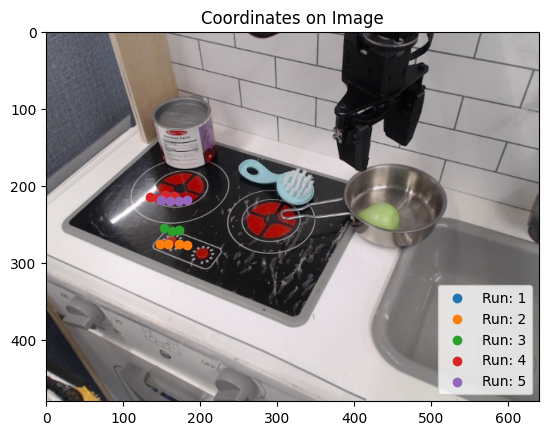

Task: 2
pick up red srewdriver

Run: 1 - Output: [(0.505, 0.571), (0.486, 0.571), (0.520, 0.575)]
Run: 2 - Output: [(0.511, 0.681), (0.536, 0.690), (0.552, 0.685), (0.527, 0.671)]
Run: 3 - Output: [(0.519, 0.617), (0.534, 0.613), (0.503, 0.615)]
Run: 4 - Output: [(0.503, 0.656), (0.520, 0.665), (0.537, 0.656), (0.553, 0.654)]
Run: 5 - Output: [(0.502, 0.656), (0.484, 0.660), (0.519, 0.652)]


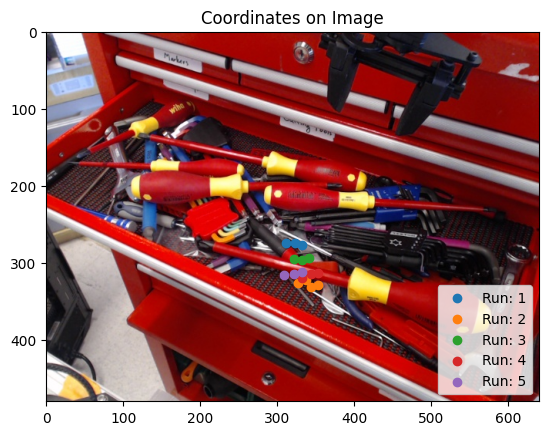

Task: 3
take the eggplant and put it between the two right burners

Run: 1 - Output: [(0.466, 0.502), (0.481, 0.506), (0.448, 0.504), (0.497, 0.508)]
Run: 2 - Output: [(0.497, 0.523), (0.514, 0.523), (0.477, 0.519), (0.530, 0.521)]
Run: 3 - Output: [(0.466, 0.506), (0.483, 0.502), (0.450, 0.515)]
Run: 4 - Output: [(0.439, 0.504), (0.455, 0.500), (0.420, 0.504)]
Run: 5 - Output: [(0.452, 0.502), (0.434, 0.500), (0.469, 0.500)]


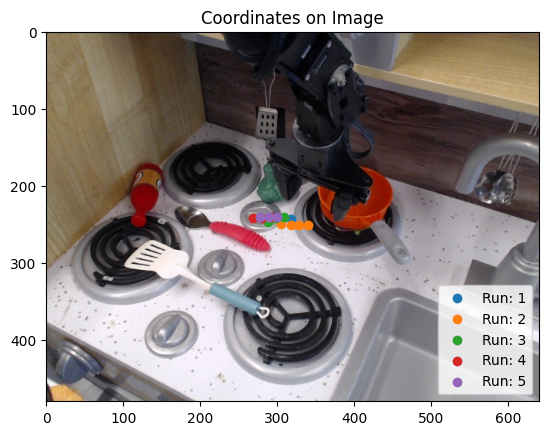

Task: 4
move arch on the table and place it on top of another arch

Run: 1 - Output: [(0.472, 0.623), (0.455, 0.623), (0.487, 0.621)]
Run: 2 - Output: [(0.484, 0.704), (0.464, 0.704), (0.445, 0.706), (0.472, 0.685)]
Run: 3 - Output: [(0.402, 0.748), (0.419, 0.731), (0.434, 0.729), (0.450, 0.727), (0.417, 0.752)]
Run: 4 - Output: [(0.439, 0.702), (0.414, 0.698), (0.455, 0.700)]
Run: 5 - Output: [(0.569, 0.679), (0.552, 0.673), (0.536, 0.675), (0.584, 0.677)]


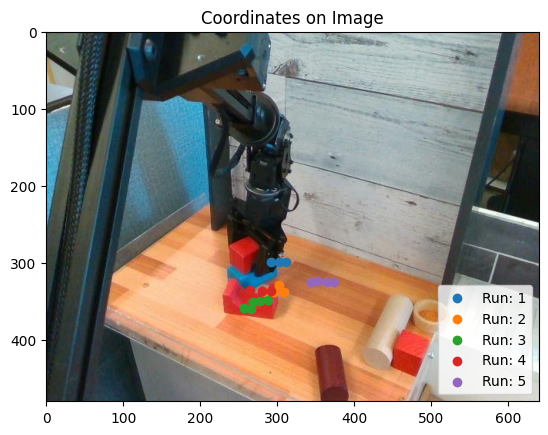

Task: 5
take sushi out of pan

Run: 1 - Output: [(0.303, 0.504), (0.287, 0.496), (0.322, 0.502), (0.272, 0.494)]
Run: 2 - Output: [(0.352, 0.429), (0.333, 0.438), (0.319, 0.425), (0.303, 0.427)]
Run: 3 - Output: [(0.344, 0.502), (0.372, 0.498), (0.356, 0.487), (0.328, 0.504)]
Run: 4 - Output: [(0.389, 0.450), (0.373, 0.446), (0.348, 0.442), (0.333, 0.450), (0.366, 0.427), (0.355, 0.463), (0.383, 0.425)]
Run: 5 - Output: [(0.256, 0.519), (0.281, 0.517), (0.241, 0.515), (0.297, 0.512)]


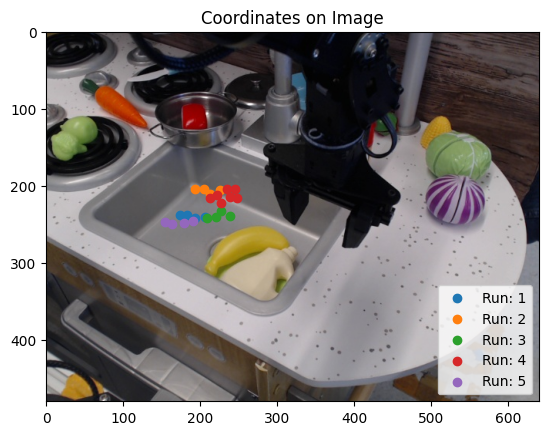

Task: 6
pick up glass cup

Run: 1 - Output: [(0.341, 0.402), (0.323, 0.402), (0.356, 0.404)]
Run: 2 - Output: [(0.383, 0.433), (0.400, 0.433), (0.367, 0.431)]
Run: 3 - Output: [(0.377, 0.637), (0.397, 0.637), (0.359, 0.633), (0.414, 0.635)]
Run: 4 - Output: [(0.588, 0.546), (0.572, 0.554), (0.552, 0.560), (0.536, 0.556), (0.567, 0.533)]
Run: 5 - Output: [(0.372, 0.369), (0.353, 0.373), (0.388, 0.367)]


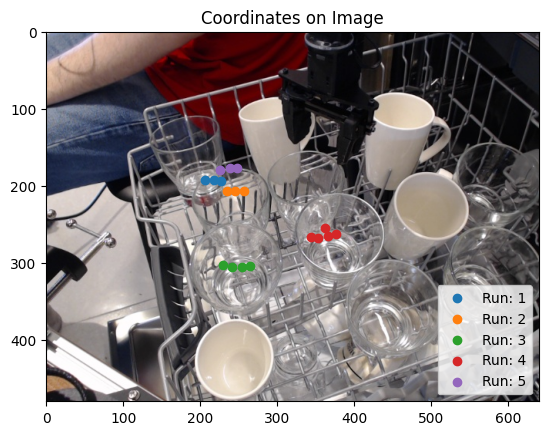

Task: 7
open low fridge

Run: 1 - Output: [(0.444, 0.171), (0.483, 0.173), (0.466, 0.171), (0.428, 0.167)]
Run: 2 - Output: [(0.433, 0.183), (0.452, 0.179), (0.470, 0.179), (0.417, 0.181)]
Run: 3 - Output: [(0.498, 0.173), (0.483, 0.175), (0.467, 0.171), (0.514, 0.171)]
Run: 4 - Output: [(0.481, 0.188), (0.461, 0.190), (0.497, 0.190)]
Run: 5 - Output: [(0.464, 0.150), (0.441, 0.144), (0.481, 0.150), (0.425, 0.146)]


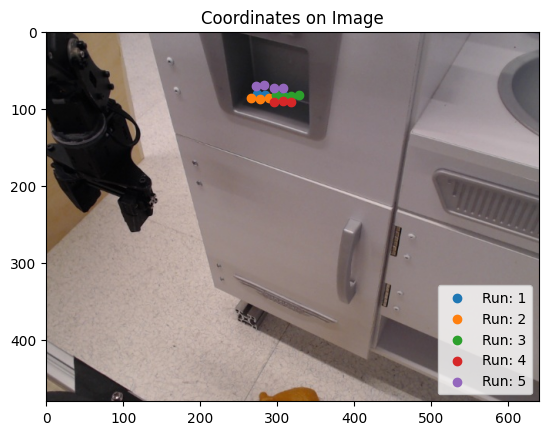

Task: 8
Place the pot to the right of the blue fork.
Move silver pot to lower right corner of the table.

Run: 1 - Output: [(0.588, 0.552), (0.619, 0.517), (0.603, 0.537), (0.634, 0.510), (0.650, 0.512), (0.586, 0.529), (0.619, 0.540), (0.603, 0.515)]
Run: 2 - Output: [(0.592, 0.577), (0.539, 0.588), (0.575, 0.571), (0.555, 0.579), (0.523, 0.590)]
Run: 3 - Output: [(0.480, 0.569), (0.489, 0.548), (0.458, 0.556), (0.505, 0.556), (0.473, 0.548), (0.442, 0.554)]
Run: 4 - Output: [(0.558, 0.583), (0.592, 0.596), (0.577, 0.588), (0.537, 0.585), (0.519, 0.581), (0.575, 0.610), (0.559, 0.604)]
Run: 5 - Output: [(0.573, 0.552), (0.528, 0.554), (0.545, 0.558), (0.591, 0.552), (0.508, 0.554), (0.559, 0.542)]


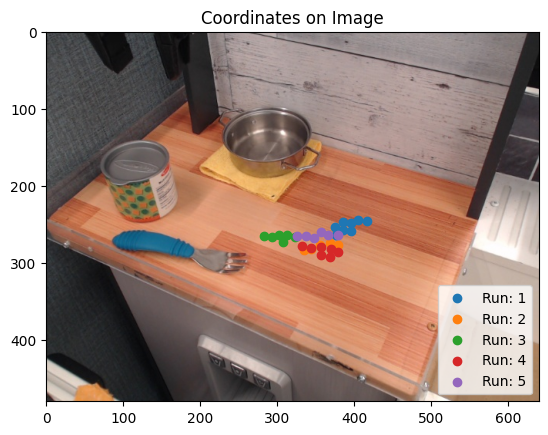

In [15]:
#tasks, images = extract_tasks_and_images("./data")
tasks, images = extract_tasks_and_images("./xai-praktikum/molmo/data2")

#for i in range(len(tasks)):
for i in range(len(tasks)):   
    print(f"Task: {i + 1}")
    image = images[i]
    task = tasks[i]

    labels = []
    coordinate_list = []
    print(tasks[i])

    
    for j in range(5):
        labels.append(f"Run: {j + 1}")

        prompt = generate_prompt(task)
        output,loglikelihood = do_inference_on_image_with_loglikelihood(image, prompt, 0.2)
        coordinate_list.append(extract_coordinates(output))
    
        print(f"Run: {j + 1} - Output: {output} - Loglikelihood: {loglikelihood}")

    visualize_points_on_image(image, labels, coordinate_list)

    



Task: 1
Move the can from the top left of the burner to the bottom left of the burner
A chat between a curious human and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the human's questions. USER: <image>
Locate several points within the vacant space of the can.Your answer should be formatted as a list of tuples, i.e. [(x1, y1), (x2, y2), ...], where each tuple contains the x and y coordinates of a point satisfying the conditions above. The coordinates should be between 0 and 1, indicating the normalized pixel locations of the points in the image. ASSISTANT:


From v4.47 onwards, when a model cache is to be returned, `generate` will return a `Cache` instance instead by default (as opposed to the legacy tuple of tuples format). If you want to keep returning the legacy format, please set `return_legacy_cache=True`.


Run: 1 - Output: [(0.297, 0.585), (0.277, 0.567), (0.241, 0.583), (0.258, 0.585), (0.239, 0.562), (0.256, 0.565), (0.305, 0.567)] - Loglikelihood: -40.16771697998047
Run: 2 - Output: [(0.272, 0.615), (0.302, 0.606), (0.287, 0.619), (0.256, 0.610)] - Loglikelihood: -24.84806251525879
Run: 3 - Output: [(0.283, 0.448), (0.312, 0.458), (0.297, 0.463), (0.306, 0.438)] - Loglikelihood: -24.362056732177734
Run: 4 - Output: [(0.283, 0.573), (0.258, 0.571), (0.298, 0.569), (0.269, 0.590), (0.275, 0.554)] - Loglikelihood: -29.649398803710938
Run: 5 - Output: [(0.289, 0.577), (0.306, 0.565)] - Loglikelihood: -14.830978393554688


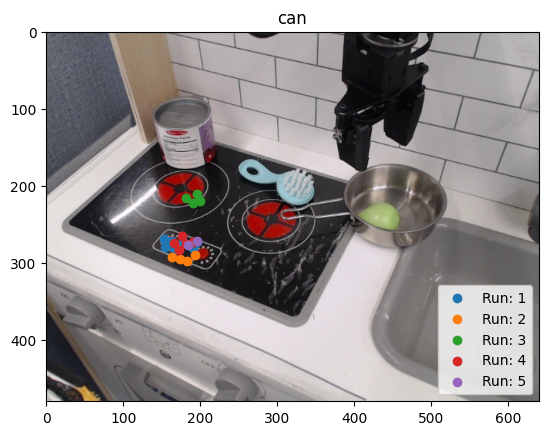

A chat between a curious human and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the human's questions. USER: <image>
Locate several points within the vacant space of the top left of the burner.Your answer should be formatted as a list of tuples, i.e. [(x1, y1), (x2, y2), ...], where each tuple contains the x and y coordinates of a point satisfying the conditions above. The coordinates should be between 0 and 1, indicating the normalized pixel locations of the points in the image. ASSISTANT:
Run: 1 - Output: [(0.280, 0.417), (0.261, 0.429), (0.239, 0.421), (0.255, 0.406)] - Loglikelihood: -24.751502990722656
Run: 2 - Output: [(0.256, 0.492), (0.286, 0.492), (0.227, 0.496), (0.294, 0.473), (0.273, 0.477), (0.241, 0.483), (0.208, 0.498)] - Loglikelihood: -39.8994140625
Run: 3 - Output: [(0.206, 0.479), (0.183, 0.471), (0.225, 0.467), (0.164, 0.465), (0.147, 0.469), (0.198, 0.458)] - Loglikelihood: -36.00450134277344
Run: 4 - Output: [(

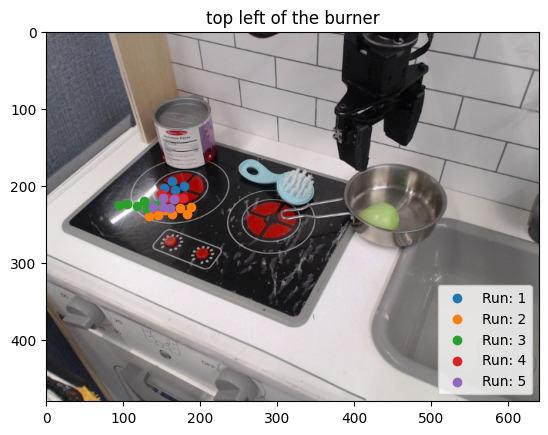

A chat between a curious human and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the human's questions. USER: <image>
Locate several points within the vacant space of the bottom left of the burner.Your answer should be formatted as a list of tuples, i.e. [(x1, y1), (x2, y2), ...], where each tuple contains the x and y coordinates of a point satisfying the conditions above. The coordinates should be between 0 and 1, indicating the normalized pixel locations of the points in the image. ASSISTANT:
Run: 1 - Output: [(0.212, 0.727), (0.208, 0.667), (0.231, 0.729), (0.234, 0.673), (0.211, 0.706), (0.220, 0.683), (0.220, 0.654), (0.205, 0.646), (0.197, 0.690)] - Loglikelihood: -55.53485107421875
Run: 2 - Output: [(0.273, 0.625), (0.214, 0.623), (0.256, 0.617), (0.230, 0.627), (0.241, 0.608), (0.289, 0.621)] - Loglikelihood: -37.35731887817383
Run: 3 - Output: [(0.205, 0.698), (0.197, 0.679), (0.178, 0.677), (0.227, 0.683), (0.216, 0.667)] -

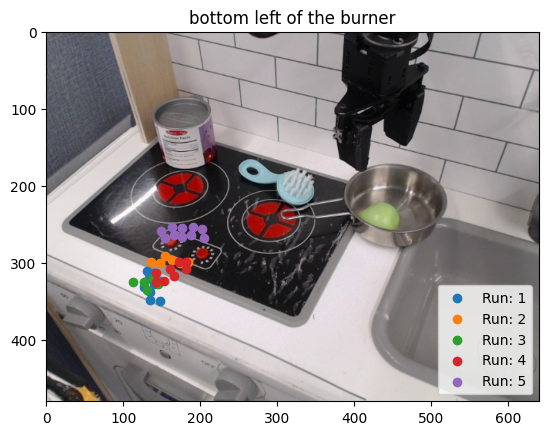

Task: 2
pick up red srewdriver
A chat between a curious human and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the human's questions. USER: <image>
Locate several points within the vacant space of the red screwdriver.Your answer should be formatted as a list of tuples, i.e. [(x1, y1), (x2, y2), ...], where each tuple contains the x and y coordinates of a point satisfying the conditions above. The coordinates should be between 0 and 1, indicating the normalized pixel locations of the points in the image. ASSISTANT:
Run: 1 - Output: [(0.486, 0.583), (0.467, 0.581), (0.503, 0.575), (0.445, 0.585)] - Loglikelihood: -27.33758544921875
Run: 2 - Output: [(0.509, 0.715), (0.531, 0.713), (0.505, 0.690), (0.486, 0.694), (0.492, 0.715)] - Loglikelihood: -33.53688049316406
Run: 3 - Output: [(0.472, 0.637), (0.548, 0.677), (0.533, 0.717), (0.522, 0.667), (0.498, 0.677), (0.517, 0.692), (0.506, 0.648), (0.534, 0.685), (0.487, 0.640), (0.470, 0.66

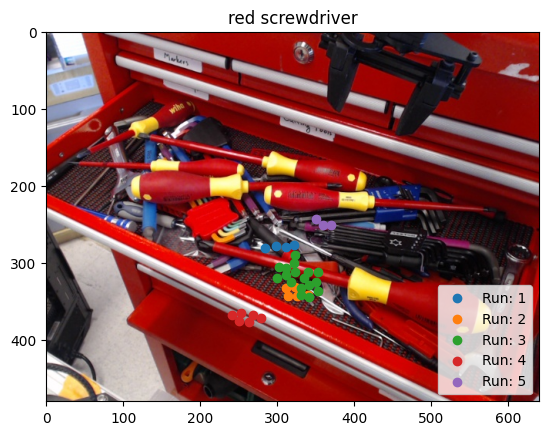

Task: 3
take the eggplant and put it between the two right burners
A chat between a curious human and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the human's questions. USER: <image>
Locate several points within the vacant space of the eggplant.Your answer should be formatted as a list of tuples, i.e. [(x1, y1), (x2, y2), ...], where each tuple contains the x and y coordinates of a point satisfying the conditions above. The coordinates should be between 0 and 1, indicating the normalized pixel locations of the points in the image. ASSISTANT:
Run: 1 - Output: [(0.487, 0.546), (0.475, 0.571), (0.444, 0.569), (0.461, 0.560), (0.459, 0.540)] - Loglikelihood: -29.619129180908203
Run: 2 - Output: [(0.403, 0.856), (0.384, 0.863), (0.419, 0.854), (0.434, 0.850)] - Loglikelihood: -28.841001510620117
Run: 3 - Output: [(0.316, 0.577), (0.298, 0.594), (0.291, 0.558), (0.273, 0.573), (0.333, 0.577), (0.298, 0.537), (0.281, 0.592), (0.314, 0.556

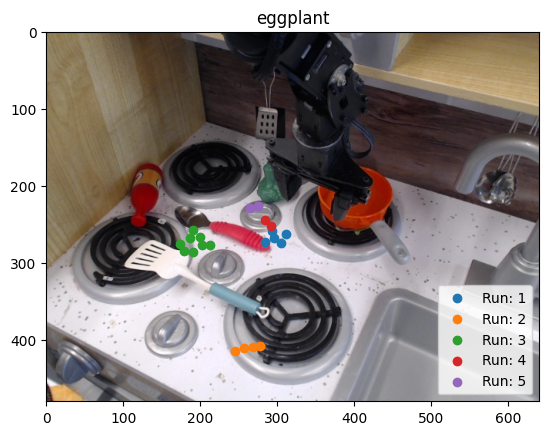

A chat between a curious human and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the human's questions. USER: <image>
Locate several points within the vacant space of the between the two right burners.Your answer should be formatted as a list of tuples, i.e. [(x1, y1), (x2, y2), ...], where each tuple contains the x and y coordinates of a point satisfying the conditions above. The coordinates should be between 0 and 1, indicating the normalized pixel locations of the points in the image. ASSISTANT:
Run: 1 - Output: [(0.481, 0.546), (0.466, 0.548), (0.452, 0.535)] - Loglikelihood: -20.306198120117188
Run: 2 - Output: [(0.439, 0.519), (0.416, 0.535), (0.455, 0.517)] - Loglikelihood: -19.666183471679688
Run: 3 - Output: [(0.452, 0.519), (0.431, 0.525), (0.438, 0.504), (0.417, 0.506), (0.416, 0.527)] - Loglikelihood: -27.760156631469727
Run: 4 - Output: [(0.405, 0.510), (0.458, 0.500), (0.423, 0.490), (0.406, 0.485), (0.428, 0.515), (0.4

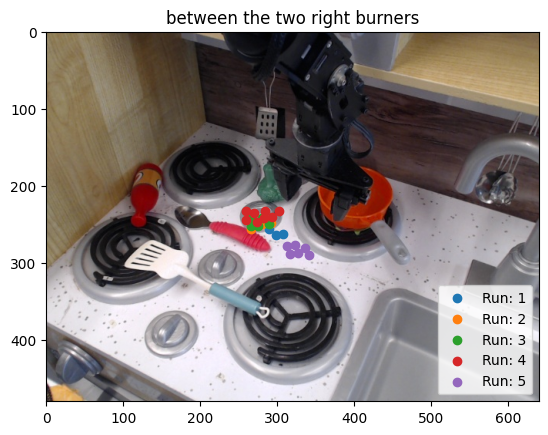

Task: 4
move arch on the table and place it on top of another arch
A chat between a curious human and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the human's questions. USER: <image>
Locate several points within the vacant space of the arch on table.Your answer should be formatted as a list of tuples, i.e. [(x1, y1), (x2, y2), ...], where each tuple contains the x and y coordinates of a point satisfying the conditions above. The coordinates should be between 0 and 1, indicating the normalized pixel locations of the points in the image. ASSISTANT:
Run: 1 - Output: [(0.528, 0.750), (0.548, 0.762), (0.503, 0.731), (0.544, 0.742), (0.486, 0.744), (0.511, 0.752)] - Loglikelihood: -38.789222717285156
Run: 2 - Output: [(0.511, 0.773), (0.559, 0.750), (0.548, 0.723), (0.581, 0.746), (0.533, 0.752), (0.531, 0.775), (0.583, 0.767), (0.544, 0.790), (0.561, 0.775), (0.559, 0.706), (0.545, 0.769), (0.575, 0.725), (0.528, 0.731)] - Loglikelihood

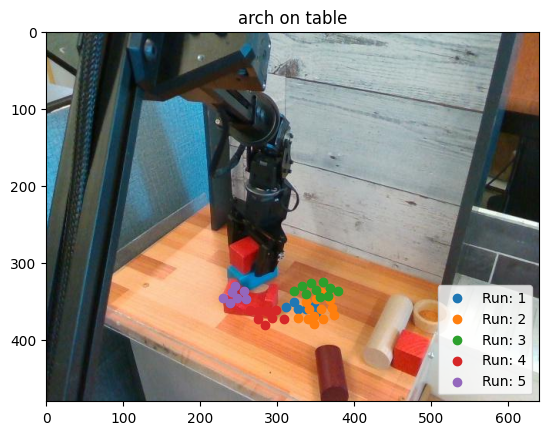

A chat between a curious human and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the human's questions. USER: <image>
Locate several points within the vacant space of the table.Your answer should be formatted as a list of tuples, i.e. [(x1, y1), (x2, y2), ...], where each tuple contains the x and y coordinates of a point satisfying the conditions above. The coordinates should be between 0 and 1, indicating the normalized pixel locations of the points in the image. ASSISTANT:
Run: 1 - Output: [(0.487, 0.731), (0.455, 0.756), (0.473, 0.713), (0.483, 0.758), (0.456, 0.721), (0.472, 0.740), (0.491, 0.708)] - Loglikelihood: -43.32416534423828
Run: 2 - Output: [(0.433, 0.863), (0.477, 0.840), (0.447, 0.835), (0.459, 0.865), (0.442, 0.885), (0.491, 0.850), (0.422, 0.844), (0.461, 0.831)] - Loglikelihood: -49.30429458618164
Run: 3 - Output: [(0.598, 0.704), (0.625, 0.700), (0.580, 0.694), (0.564, 0.698)] - Loglikelihood: -28.627025604248047


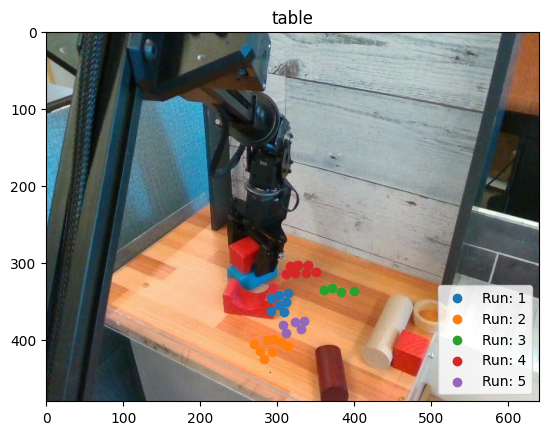

A chat between a curious human and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the human's questions. USER: <image>
Locate several points within the vacant space of the top of the arch.Your answer should be formatted as a list of tuples, i.e. [(x1, y1), (x2, y2), ...], where each tuple contains the x and y coordinates of a point satisfying the conditions above. The coordinates should be between 0 and 1, indicating the normalized pixel locations of the points in the image. ASSISTANT:
Run: 1 - Output: [(0.566, 0.625), (0.547, 0.625), (0.539, 0.606), (0.520, 0.604), (0.583, 0.633), (0.555, 0.644), (0.566, 0.602)] - Loglikelihood: -42.288421630859375
Run: 2 - Output: [(0.502, 0.596), (0.522, 0.596), (0.537, 0.594)] - Loglikelihood: -21.454025268554688
Run: 3 - Output: [(0.534, 0.573), (0.606, 0.600), (0.553, 0.577), (0.594, 0.575), (0.567, 0.565), (0.589, 0.598), (0.572, 0.590), (0.556, 0.598), (0.609, 0.577), (0.572, 0.610), (0.541, 0

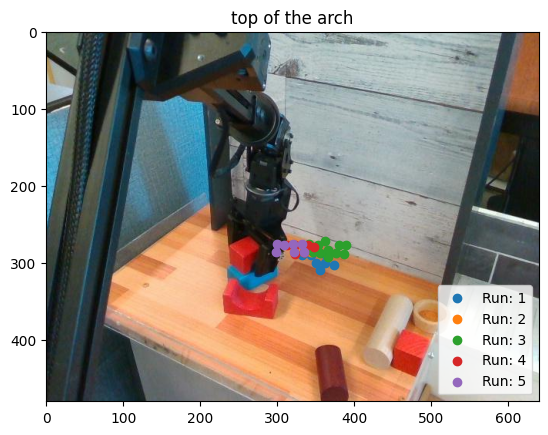

Task: 5
take sushi out of pan
A chat between a curious human and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the human's questions. USER: <image>
Locate several points within the vacant space of the sushi.Your answer should be formatted as a list of tuples, i.e. [(x1, y1), (x2, y2), ...], where each tuple contains the x and y coordinates of a point satisfying the conditions above. The coordinates should be between 0 and 1, indicating the normalized pixel locations of the points in the image. ASSISTANT:
Run: 1 - Output: [(0.266, 0.517), (0.244, 0.519), (0.267, 0.494), (0.286, 0.529), (0.305, 0.521), (0.230, 0.502), (0.284, 0.506), (0.320, 0.510)] - Loglikelihood: -47.83414840698242
Run: 2 - Output: [(0.280, 0.579), (0.312, 0.548), (0.297, 0.575), (0.264, 0.590), (0.331, 0.550), (0.275, 0.604), (0.314, 0.569)] - Loglikelihood: -44.13316345214844
Run: 3 - Output: [(0.417, 0.508), (0.369, 0.504), (0.395, 0.500), (0.380, 0.485), (0.352,

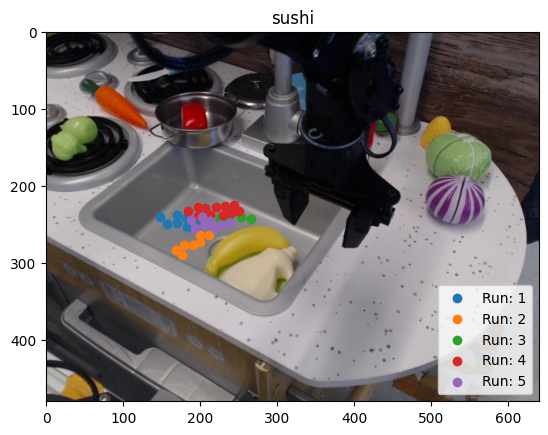

A chat between a curious human and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the human's questions. USER: <image>
Locate several points within the vacant space of the pan.Your answer should be formatted as a list of tuples, i.e. [(x1, y1), (x2, y2), ...], where each tuple contains the x and y coordinates of a point satisfying the conditions above. The coordinates should be between 0 and 1, indicating the normalized pixel locations of the points in the image. ASSISTANT:
Run: 1 - Output: [(0.377, 0.567), (0.400, 0.562), (0.428, 0.550), (0.383, 0.544), (0.414, 0.542), (0.417, 0.567), (0.397, 0.533)] - Loglikelihood: -40.94169998168945
Run: 2 - Output: [(0.289, 0.506), (0.272, 0.502), (0.369, 0.485), (0.386, 0.473), (0.305, 0.502), (0.352, 0.479)] - Loglikelihood: -40.35331344604492
Run: 3 - Output: [(0.297, 0.485), (0.322, 0.490), (0.275, 0.483), (0.266, 0.458), (0.280, 0.448), (0.308, 0.467), (0.328, 0.467), (0.289, 0.467)] - Logli

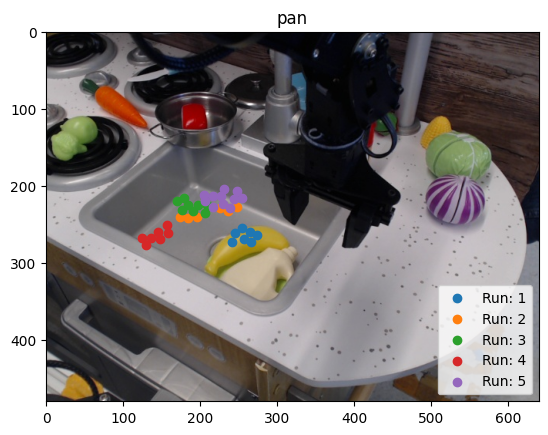

Task: 6
pick up glass cup
A chat between a curious human and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the human's questions. USER: <image>
Locate several points within the vacant space of the glass cup.Your answer should be formatted as a list of tuples, i.e. [(x1, y1), (x2, y2), ...], where each tuple contains the x and y coordinates of a point satisfying the conditions above. The coordinates should be between 0 and 1, indicating the normalized pixel locations of the points in the image. ASSISTANT:
Run: 1 - Output: [(0.428, 0.623), (0.436, 0.602), (0.414, 0.613), (0.409, 0.633), (0.394, 0.615), (0.452, 0.600)] - Loglikelihood: -37.091487884521484
Run: 2 - Output: [(0.550, 0.602), (0.533, 0.619), (0.555, 0.625), (0.569, 0.613), (0.536, 0.640), (0.531, 0.598)] - Loglikelihood: -35.02483367919922
Run: 3 - Output: [(0.328, 0.715), (0.302, 0.710), (0.306, 0.681), (0.345, 0.715), (0.322, 0.694), (0.287, 0.721)] - Loglikelihood: -38.1

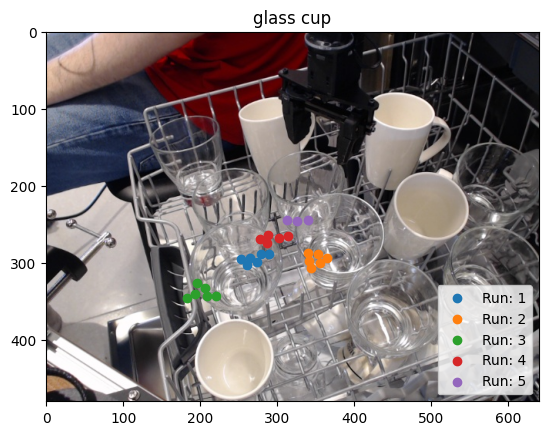

Task: 7
open low fridge
A chat between a curious human and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the human's questions. USER: <image>
Locate several points within the vacant space of the low fridge.Your answer should be formatted as a list of tuples, i.e. [(x1, y1), (x2, y2), ...], where each tuple contains the x and y coordinates of a point satisfying the conditions above. The coordinates should be between 0 and 1, indicating the normalized pixel locations of the points in the image. ASSISTANT:
Run: 1 - Output: [(0.523, 0.150), (0.506, 0.152), (0.531, 0.175), (0.542, 0.150), (0.537, 0.129), (0.497, 0.133), (0.516, 0.129), (0.553, 0.131)] - Loglikelihood: -41.832977294921875
Run: 2 - Output: [(0.455, 0.190), (0.467, 0.175), (0.477, 0.194), (0.442, 0.175)] - Loglikelihood: -24.26927375793457
Run: 3 - Output: [(0.509, 0.217), (0.486, 0.217), (0.527, 0.212), (0.466, 0.219)] - Loglikelihood: -24.910015106201172
Run: 4 - Output: [

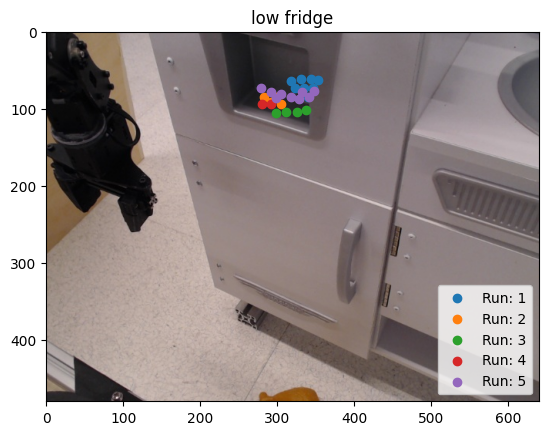

Task: 8
Place the pot to the right of the blue fork.
Move silver pot to lower right corner of the table.
A chat between a curious human and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the human's questions. USER: <image>
Locate several points within the vacant space of the pot.Your answer should be formatted as a list of tuples, i.e. [(x1, y1), (x2, y2), ...], where each tuple contains the x and y coordinates of a point satisfying the conditions above. The coordinates should be between 0 and 1, indicating the normalized pixel locations of the points in the image. ASSISTANT:
Run: 1 - Output: [(0.519, 0.494), (0.539, 0.498), (0.556, 0.508), (0.572, 0.519), (0.531, 0.479), (0.556, 0.485), (0.503, 0.475), (0.523, 0.515)] - Loglikelihood: -47.501983642578125
Run: 2 - Output: [(0.497, 0.419), (0.517, 0.425), (0.533, 0.427), (0.530, 0.406), (0.514, 0.404)] - Loglikelihood: -31.98483657836914
Run: 3 - Output: [(0.400, 0.590), (0.439, 0.529

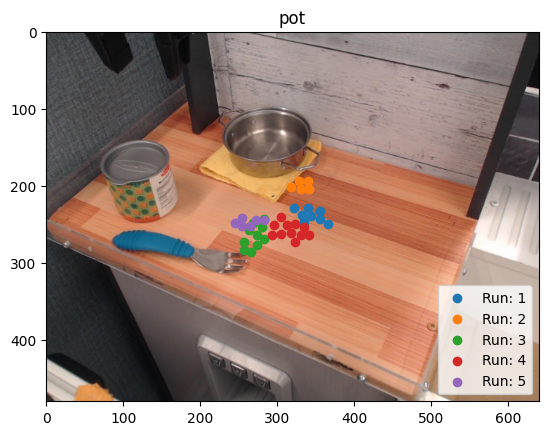

A chat between a curious human and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the human's questions. USER: <image>
Locate several points within the vacant space of the right of the blue fork.Your answer should be formatted as a list of tuples, i.e. [(x1, y1), (x2, y2), ...], where each tuple contains the x and y coordinates of a point satisfying the conditions above. The coordinates should be between 0 and 1, indicating the normalized pixel locations of the points in the image. ASSISTANT:
Run: 1 - Output: [(0.509, 0.535), (0.511, 0.567), (0.436, 0.560), (0.477, 0.537), (0.495, 0.569), (0.456, 0.569), (0.484, 0.585), (0.494, 0.546), (0.470, 0.590), (0.470, 0.560), (0.522, 0.550), (0.453, 0.548)] - Loglikelihood: -70.03849792480469
Run: 2 - Output: [(0.517, 0.581), (0.567, 0.573), (0.591, 0.562), (0.523, 0.546), (0.542, 0.571), (0.564, 0.542), (0.509, 0.556), (0.547, 0.548), (0.583, 0.544), (0.500, 0.577)] - Loglikelihood: -62.49998

In [ ]:
#tasks, images = extract_tasks_and_images("./data")
tasks, images, object_list = extract_tasks_and_images_and_objects("./xai-praktikum/molmo/data2")

#for i in range(len(tasks)):
for i in range(len(tasks)):   
    print(f"Task: {i + 1}")
    image = images[i]
    task = tasks[i]
    objects = object_list[i]

    print(tasks[i])

    for object in objects:
        labels = []
        coordinate_list = []
        prompt = generate_prompt(object, "Locate several points within the vacant space of the ")
        print(prompt)
        for j in range(2):
            labels.append(f"Run: {j + 1}")
            output, loglikelihood = do_inference_on_image_with_loglikelihood(image, prompt, 0.3)
            coordinate_list.append(extract_coordinates(output))
        
            print(f"Run: {j + 1} - Output: {output} - Loglikelihood: {loglikelihood}")
        visualize_points_on_image(image, labels, coordinate_list, object)


Task: 1
Move the can from the top left of the burner to the bottom left of the burner

Prompt: 1 - Output: [(0.223, 0.369), (0.255, 0.379)]
Prompt: 2 - Output: [(0.275, 0.475), (0.289, 0.487)]
Prompt: 3 - Output: [(0.267, 0.460), (0.220, 0.458), (0.236, 0.454), (0.252, 0.465)]
Prompt: 4 - Output: [(0.295, 0.290), (0.314, 0.279), (0.280, 0.287)]
Prompt: 5 - Output: [(0.294, 0.515), (0.311, 0.510), (0.330, 0.512)]


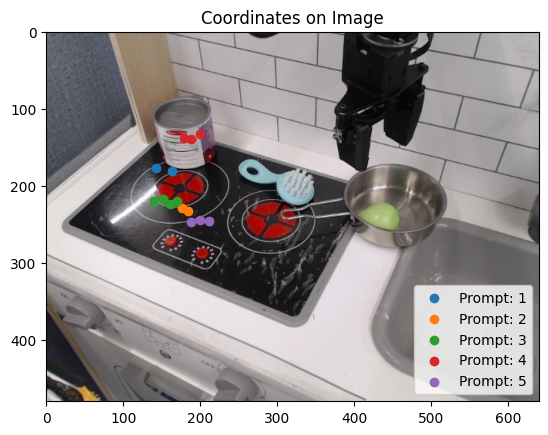

In [16]:
#tasks, images = extract_tasks_and_images("./data")
tasks, images = extract_tasks_and_images("./xai-praktikum/molmo/data2")

prompts = [
    "Locate several points within the vacant space for the following task: Move the can from the top left of the burner to the bottom left of the burner",
    "Locate several points within the vacant space of the bottom left of the burner",
    "Pinpoint several points within the vacant space of the top left of the burner",
    "Pinpoint several points within the vacant space around the can in the top left of the burner",
    "Locate several points within the free space between the two burners"
]

#for i in range(len(tasks)):
for i in [0]:   
    print(f"Task: {i + 1}")
    image = images[i]
    task = tasks[i]

    labels = []
    coordinate_list = []
    print(tasks[i])
    
    for j in range(len(prompts)):
        labels.append(f"Prompt: {j + 1}")

        prompt = generate_prompt("", prompts[j])
        output = do_inference_on_image(image, prompt, 0.5)
        coordinate_list.append(extract_coordinates(output))
    
        print(f"Prompt: {j + 1} - Output: {output}")

    visualize_points_on_image(image, labels, coordinate_list)

    



In [7]:
import numpy as np
def do_inference_test(image, prompt, temperature=0.2):
    # prepare inputs for the model
    input_ids = tokenizer_image_token(prompt, tokenizer, -200, return_tensors='pt').unsqueeze(0).cuda()
    
    # prepare image input
    image_tensor = process_images([image], image_processor, model.config)[0].unsqueeze(0).half().cuda()
    
    # autoregressively generate text
    with torch.no_grad():
        outputs = model.generate(
            input_ids,
            images=image_tensor,
            #image_sizes=[image.size],
            do_sample=True,
            temperature=temperature,
            max_new_tokens=1024,
            output_scores=True,
            output_logits=True,
            return_dict_in_generate=True,
            use_cache=True)

    # Extract generated IDs and scores
    generated_ids = outputs.sequences
    print(generated_ids.shape)
    # Decode text output
    output = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()

    for token in generated_ids[0]:
        print(token)
        print(tokenizer.decode(token.item(), skip_special_tokens=True)[0].strip())

    logits = outputs.logits # Shape: [batch_size, seq_len, vocab_size]
    logits = torch.cat(logits, dim=0)
    print(logits.shape)
    softmax_fn = torch.nn.Softmax(dim=-1)

    logit_probs = softmax_fn(logits)
    highest_probs, _ = torch.max(logit_probs, dim=-1)
    print(highest_probs)
    output_log_probs = torch.log(highest_probs)
    log_likelihood = torch.sum(output_log_probs)

    print(len(output))
    
    return output, log_likelihood.item()


#tasks, images = extract_tasks_and_images("./data")
tasks, images, object_list = extract_tasks_and_images_and_objects("./xai-praktikum/molmo/data2")

#for i in range(len(tasks)):
for i in [0,1]:   
    print(f"Task: {i + 1}")
    image = images[i]
    task = tasks[i]
    objects = object_list[i]

    print(tasks[i])

    for object in objects:
        labels = []
        coordinate_list = []
        prompt = generate_prompt(object, "Locate several points within the vacant space of the ")
        for j in range(2):
            labels.append(f"Run: {j + 1}")
            output, loglikelihood = do_inference_test(image, prompt, 0.3)
            coordinate_list.append(extract_coordinates(output))
        
            print(f"Run: {j + 1} - Output: {output} - Loglikelihood: {loglikelihood}")
        visualize_points_on_image(image, labels, coordinate_list, object)


Task: 1
Move the can from the top left of the burner to the bottom left of the burner


/home/kit/stud/uutqh/.local/lib/python3.9/site-packages/transformers/generation/utils.py:1493: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed in v5. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
From v4.47 onwards, when a model cache is to be returned, `generate` will return a `Cache` instance instead by default (as opposed to the legacy tuple of tuples format). If you want to keep returning the legacy format, please set `return_legacy_cache=True`.


torch.Size([1, 113])
tensor(17288, device='cuda:0')
[
tensor(29900, device='cuda:0')
0
tensor(29889, device='cuda:0')
.
tensor(29906, device='cuda:0')
2
tensor(29929, device='cuda:0')
9
tensor(29946, device='cuda:0')
4
tensor(29892, device='cuda:0')
,
tensor(29871, device='cuda:0')


IndexError: string index out of range